In [1]:
%pip install astro-datasets numpy matplotlib albumentations adapt

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import time, sys, os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import astro_datasets
import matplotlib.pyplot as plt
import albumentations as alb
from adapt.feature_based import MDD
from adapt.utils import UpdateLambda

2022-12-08 15:43:28.805864: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
(cmd_train, cmd_test, cmd_val), info = tfds.load(name='cmd', 
                                                 split=['train[0%:90%]','train[90%:95%]','train[95%:100%]'], 
                                                 with_info=True, 
                                                 as_supervised=True, 
                                                 builder_kwargs={'simulation': 'IllustrisTNG', 'field': 'T', 
                                                 'parameters': ['omegam']})

2022-12-08 15:43:31.282267: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/IllustrisTNG_T_omegam/cmd/1.0.4.incompleteXIQLNF/cmd-train.tfrecord*...:  …

Dataset cmd downloaded and prepared to /root/tensorflow_datasets/IllustrisTNG_T_omegam/cmd/1.0.4. Subsequent calls will reuse this data.


2022-12-08 15:47:59.941539: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 15:48:00.443753: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78935 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0a:00.0, compute capability: 8.0


In [4]:
(simba_train, simba_test, simba_val), info_simba = tfds.load(name='cmd', 
                                                 split=['train[0%:90%]','train[90%:95%]','train[95%:100%]'], 
                                                 with_info=True, 
                                                 as_supervised=True, 
                                                 builder_kwargs={'simulation': 'SIMBA', 'field': 'T', 
                                                 'parameters': ['omegam']})

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/SIMBA_T_omegam/cmd/1.0.4.incompleteJ6DJG5/cmd-train.tfrecord*...:   0%|   …

Dataset cmd downloaded and prepared to /root/tensorflow_datasets/SIMBA_T_omegam/cmd/1.0.4. Subsequent calls will reuse this data.


In [5]:
# define preprocessing, normalization and augmentation functions

def normalize(image, label):  
    image = tf.math.asinh(image)
    image = image - 26
    return image, label

def aug_fn(image):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[256, 256])
    return aug_img

def process_data(image, label):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image],\
                                Tout=tf.float32)
    return aug_img, label

def set_shapes(img, label, img_shape=(256, 256, 1)):
    img.set_shape(img_shape)
    label.set_shape(1,)
    return img, label


# Separating images from labels

def get_features(features, labels):
    return features
 
def get_labels(features, labels):
    return labels

# Define augmentation pipeline

transforms = alb.Compose([alb.VerticalFlip(p=0.6),
                          alb.HorizontalFlip(p=0.6),
                          alb.RandomRotate90(p=0.6)])


In [6]:
btch_size = 128

In [7]:
cmd_train = cmd_train.repeat(count=3) # increase dataset size
cmd_train = cmd_train.map(process_data)
cmd_train = cmd_train.map(set_shapes)
cmd_train = cmd_train.map(normalize)
cmd_train = cmd_train.batch(btch_size).prefetch(tf.data.AUTOTUNE)

cmd_test = cmd_test.map(normalize)
cmd_test = cmd_test.batch(btch_size).prefetch(tf.data.AUTOTUNE)

cmd_val = cmd_val.map(normalize)
cmd_val = cmd_val.batch(btch_size).prefetch(tf.data.AUTOTUNE)

In [8]:
simba_test = simba_test.map(normalize)
simba_test = simba_test.batch(btch_size).prefetch(tf.data.AUTOTUNE)

simba_train = simba_train.map(normalize)
simba_train = simba_train.batch(btch_size).prefetch(tf.data.AUTOTUNE)

In [9]:
H = 7

In [10]:
encoder = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(2*H, kernel_size=3, strides=1, padding = 'same', input_shape=(256, 256, 1)),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(2*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(2*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(4*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(4*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(4*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),  
  tf.keras.layers.Conv2D(8*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(8*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(8*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),    
  tf.keras.layers.Conv2D(16*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(16*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(16*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),    
  tf.keras.layers.Conv2D(32*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(32*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(32*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(64*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(64*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(64*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),  
  tf.keras.layers.Conv2D(128*H, kernel_size=4, strides=1, padding = 'valid'),  
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),  
  tf.keras.layers.Flatten()
])

In [11]:
task = tf.keras.models.Sequential([
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64*H),
    tf.keras.layers.LeakyReLU(0.2), 
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Dense(1)
])

In [12]:
opt = tf.keras.optimizers.Adam(beta_1=0.5, beta_2=0.999)
opt_enc = tf.keras.optimizers.Adam(beta_1=0.5, beta_2=0.999)
opt_disc = tf.keras.optimizers.Adam(beta_1=0.5, beta_2=0.999)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10)

In [13]:
epochs = 50

In [14]:
train_x_simba = simba_train.map(get_features).prefetch(tf.data.AUTOTUNE)
train_y_simba = simba_train.map(get_labels).prefetch(tf.data.AUTOTUNE)

In [15]:
mdd = MDD(encoder, task,
            loss="mae",
            metrics=["mse"],
            copy=False,
            optimizer=opt,
            optimizer_enc=opt_enc,
            optimizer_disc=opt_disc)

In [16]:
checkpoint_path = "./cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,
                                                 monitor='val_loss',
                                                 mode='min',
                                                 verbose=1,
                                                 save_best_only=True)

mdd.fit(cmd_train,\
        Xt=train_x_simba,\
        epochs=epochs,\
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),\
                     reduce_lr, cp_callback],\
        validation_data=cmd_val)

2022-12-08 15:52:09.436179: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100


Epoch 1/50


2022-12-08 15:52:12.381721: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-12-08 15:52:28.665272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 54 of 317
2022-12-08 15:52:38.690105: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 102 of 317
2022-12-08 15:52:48.642955: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 151 of 317
2022-12-08 15:52:58.600073: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 209 of 317
2022-12-08 15:53:09.033491: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 256 of 317
2022-12-08 15:53:18.675220: I tensorflow/core/kernels/data/shuffle_dataset_op.

320/320 [==============================] - ETA: 0s - loss: 0.2767 - mse: 0.5137 - disc_loss: 1.6262
Epoch 1: val_loss improved from inf to 0.09711, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


320/320 [==============================] - 201s 396ms/step - loss: 0.2767 - mse: 0.5137 - disc_loss: 1.6234 - val_loss: 0.0971 - val_mse: 0.0149 - lr: 0.0010
Epoch 2/50
320/320 [==============================] - ETA: 0s - loss: 0.0887 - mse: 0.0318 - disc_loss: 0.4497
Epoch 2: val_loss did not improve from 0.09711
320/320 [==============================] - 172s 371ms/step - loss: 0.0887 - mse: 0.0318 - disc_loss: 0.4498 - val_loss: 0.1152 - val_mse: 0.0189 - lr: 0.0010
Epoch 3/50


2022-12-08 15:58:35.692739: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 57 of 317
2022-12-08 15:58:45.764434: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 116 of 317
2022-12-08 15:58:55.748725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 175 of 317
2022-12-08 15:59:05.634425: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 232 of 317
2022-12-08 15:59:15.615536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 289 of 317
2022-12-08 15:59:20.303142: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0566 - mse: 0.0099 - disc_loss: 0.2714
Epoch 3: val_loss did not improve from 0.09711
320/320 [==============================] - 174s 370ms/step - loss: 0.0566 - mse: 0.0099 - disc_loss: 0.2713 - val_loss: 0.1280 - val_mse: 0.0241 - lr: 0.0010
Epoch 4/50


2022-12-08 16:01:29.376719: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 58 of 317
2022-12-08 16:01:39.400813: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 117 of 317
2022-12-08 16:01:49.402279: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 176 of 317
2022-12-08 16:01:59.482340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 236 of 317
2022-12-08 16:02:09.358187: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 293 of 317
2022-12-08 16:02:13.425391: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0368 - mse: 0.0027 - disc_loss: 0.1389
Epoch 4: val_loss did not improve from 0.09711
320/320 [==============================] - 172s 368ms/step - loss: 0.0368 - mse: 0.0027 - disc_loss: 0.1389 - val_loss: 0.1271 - val_mse: 0.0239 - lr: 0.0010
Epoch 5/50


2022-12-08 16:04:21.751699: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 59 of 317
2022-12-08 16:04:31.752636: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 119 of 317
2022-12-08 16:04:41.746482: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 177 of 317
2022-12-08 16:04:51.798228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 235 of 317
2022-12-08 16:05:01.741792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 294 of 317
2022-12-08 16:05:05.528430: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0314 - mse: 0.0018 - disc_loss: 0.1161
Epoch 5: val_loss did not improve from 0.09711
320/320 [==============================] - 173s 371ms/step - loss: 0.0314 - mse: 0.0018 - disc_loss: 0.1159 - val_loss: 0.1127 - val_mse: 0.0181 - lr: 0.0010
Epoch 6/50


2022-12-08 16:07:14.746475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 60 of 317
2022-12-08 16:07:24.706602: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 120 of 317
2022-12-08 16:07:34.863645: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 180 of 317
2022-12-08 16:07:44.793716: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 237 of 317
2022-12-08 16:07:54.703829: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 286 of 317
2022-12-08 16:08:01.190300: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0289 - mse: 0.0015 - disc_loss: 0.1128
Epoch 6: val_loss did not improve from 0.09711
320/320 [==============================] - 175s 369ms/step - loss: 0.0289 - mse: 0.0015 - disc_loss: 0.1126 - val_loss: 0.1046 - val_mse: 0.0150 - lr: 0.0010
Epoch 7/50


2022-12-08 16:10:09.883349: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 60 of 317
2022-12-08 16:10:19.920693: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 120 of 317
2022-12-08 16:10:29.924096: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 181 of 317
2022-12-08 16:10:39.895085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 241 of 317
2022-12-08 16:10:49.888750: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 300 of 317
2022-12-08 16:10:52.631633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0281 - mse: 0.0014 - disc_loss: 0.1127
Epoch 7: val_loss did not improve from 0.09711
320/320 [==============================] - 171s 368ms/step - loss: 0.0281 - mse: 0.0014 - disc_loss: 0.1132 - val_loss: 0.1119 - val_mse: 0.0179 - lr: 0.0010
Epoch 8/50


2022-12-08 16:13:01.187837: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 59 of 317
2022-12-08 16:13:11.066857: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 112 of 317
2022-12-08 16:13:21.214226: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 171 of 317
2022-12-08 16:13:31.193158: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 229 of 317
2022-12-08 16:13:41.071140: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 287 of 317
2022-12-08 16:13:45.971090: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0277 - mse: 0.0013 - disc_loss: 0.1225
Epoch 8: val_loss did not improve from 0.09711
320/320 [==============================] - 174s 370ms/step - loss: 0.0277 - mse: 0.0013 - disc_loss: 0.1225 - val_loss: 0.1616 - val_mse: 0.0395 - lr: 0.0010
Epoch 9/50


2022-12-08 16:15:55.034963: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 58 of 317
2022-12-08 16:16:04.975647: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 118 of 317
2022-12-08 16:16:15.073286: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 179 of 317
2022-12-08 16:16:25.035549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 238 of 317
2022-12-08 16:16:34.986197: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 297 of 317
2022-12-08 16:16:38.205879: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0283 - mse: 0.0014 - disc_loss: 0.1301
Epoch 9: val_loss did not improve from 0.09711
320/320 [==============================] - 173s 372ms/step - loss: 0.0283 - mse: 0.0014 - disc_loss: 0.1300 - val_loss: 0.1348 - val_mse: 0.0258 - lr: 0.0010
Epoch 10/50


2022-12-08 16:18:47.721848: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 57 of 317
2022-12-08 16:18:57.638712: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 113 of 317
2022-12-08 16:19:07.641867: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 169 of 317
2022-12-08 16:19:17.714632: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 226 of 317
2022-12-08 16:19:27.718641: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 282 of 317
2022-12-08 16:19:33.910851: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0273 - mse: 0.0013 - disc_loss: 0.1273
Epoch 10: val_loss did not improve from 0.09711
320/320 [==============================] - 176s 372ms/step - loss: 0.0273 - mse: 0.0013 - disc_loss: 0.1272 - val_loss: 0.1036 - val_mse: 0.0153 - lr: 0.0010
Epoch 11/50


2022-12-08 16:21:43.728185: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 58 of 317
2022-12-08 16:21:53.745295: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 116 of 317
2022-12-08 16:22:03.794667: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 173 of 317
2022-12-08 16:22:13.651649: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 229 of 317
2022-12-08 16:22:23.745549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 288 of 317
2022-12-08 16:22:28.926994: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0269 - mse: 0.0012 - disc_loss: 0.1239
Epoch 11: val_loss did not improve from 0.09711
320/320 [==============================] - 175s 374ms/step - loss: 0.0269 - mse: 0.0012 - disc_loss: 0.1240 - val_loss: 0.1677 - val_mse: 0.0431 - lr: 0.0010
Epoch 12/50


2022-12-08 16:24:39.065021: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 56 of 317
2022-12-08 16:24:49.078708: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 114 of 317
2022-12-08 16:24:59.137099: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 171 of 317
2022-12-08 16:25:09.192565: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 229 of 317
2022-12-08 16:25:19.122648: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 286 of 317
2022-12-08 16:25:24.487697: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0216 - mse: 7.9439e-04 - disc_loss: 0.0967
Epoch 12: val_loss did not improve from 0.09711
320/320 [==============================] - 175s 372ms/step - loss: 0.0216 - mse: 7.9439e-04 - disc_loss: 0.0966 - val_loss: 0.1034 - val_mse: 0.0150 - lr: 3.0000e-04
Epoch 13/50


2022-12-08 16:27:34.149982: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 58 of 317
2022-12-08 16:27:44.029899: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 116 of 317
2022-12-08 16:27:54.127172: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 177 of 317
2022-12-08 16:28:04.118032: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 239 of 317
2022-12-08 16:28:14.117438: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 298 of 317
2022-12-08 16:28:17.302302: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0207 - mse: 7.3784e-04 - disc_loss: 0.0772
Epoch 13: val_loss did not improve from 0.09711
320/320 [==============================] - 172s 371ms/step - loss: 0.0207 - mse: 7.3784e-04 - disc_loss: 0.0775 - val_loss: 0.5883 - val_mse: 0.4044 - lr: 3.0000e-04
Epoch 14/50


2022-12-08 16:30:26.492008: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 55 of 317
2022-12-08 16:30:36.549424: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 114 of 317
2022-12-08 16:30:46.423338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 173 of 317
2022-12-08 16:30:56.459437: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 230 of 317
2022-12-08 16:31:06.464533: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 286 of 317
2022-12-08 16:31:11.692501: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0207 - mse: 7.4533e-04 - disc_loss: 0.0872
Epoch 14: val_loss did not improve from 0.09711
320/320 [==============================] - 176s 375ms/step - loss: 0.0207 - mse: 7.4533e-04 - disc_loss: 0.0871 - val_loss: 0.0992 - val_mse: 0.0132 - lr: 3.0000e-04
Epoch 15/50


2022-12-08 16:33:22.288725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 58 of 317
2022-12-08 16:33:32.307006: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 115 of 317
2022-12-08 16:33:42.318406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 173 of 317
2022-12-08 16:33:52.330252: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 230 of 317
2022-12-08 16:34:02.318062: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 288 of 317
2022-12-08 16:34:07.451070: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0204 - mse: 7.0277e-04 - disc_loss: 0.0961
Epoch 15: val_loss did not improve from 0.09711
320/320 [==============================] - 175s 372ms/step - loss: 0.0204 - mse: 7.0277e-04 - disc_loss: 0.0962 - val_loss: 0.0984 - val_mse: 0.0137 - lr: 3.0000e-04
Epoch 16/50


2022-12-08 16:36:17.157774: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 57 of 317
2022-12-08 16:36:27.162654: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 113 of 317
2022-12-08 16:36:37.177055: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 171 of 317
2022-12-08 16:36:47.183728: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 227 of 317
2022-12-08 16:36:57.285166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 284 of 317
2022-12-08 16:37:03.032589: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0202 - mse: 6.8999e-04 - disc_loss: 0.0973
Epoch 16: val_loss improved from 0.09711 to 0.07878, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


320/320 [==============================] - 182s 393ms/step - loss: 0.0202 - mse: 6.8999e-04 - disc_loss: 0.0972 - val_loss: 0.0788 - val_mse: 0.0089 - lr: 3.0000e-04
Epoch 17/50


2022-12-08 16:39:19.555562: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 57 of 317
2022-12-08 16:39:29.572908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 113 of 317
2022-12-08 16:39:39.637533: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 173 of 317
2022-12-08 16:39:49.620143: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 231 of 317
2022-12-08 16:39:59.481171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 286 of 317
2022-12-08 16:40:04.889463: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0197 - mse: 6.6412e-04 - disc_loss: 0.0930
Epoch 17: val_loss did not improve from 0.07878
320/320 [==============================] - 176s 377ms/step - loss: 0.0197 - mse: 6.6412e-04 - disc_loss: 0.0929 - val_loss: 0.1311 - val_mse: 0.0244 - lr: 3.0000e-04
Epoch 18/50


2022-12-08 16:42:16.078177: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 57 of 317
2022-12-08 16:42:26.054992: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 116 of 317
2022-12-08 16:42:36.055717: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 175 of 317
2022-12-08 16:42:46.088625: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 231 of 317
2022-12-08 16:42:56.106423: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 284 of 317
2022-12-08 16:43:02.737813: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0197 - mse: 6.5851e-04 - disc_loss: 0.1003
Epoch 18: val_loss did not improve from 0.07878
320/320 [==============================] - 178s 379ms/step - loss: 0.0197 - mse: 6.5851e-04 - disc_loss: 0.1004 - val_loss: 0.1351 - val_mse: 0.0265 - lr: 3.0000e-04
Epoch 19/50


2022-12-08 16:45:14.466042: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 56 of 317
2022-12-08 16:45:24.525711: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 113 of 317
2022-12-08 16:45:34.571190: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 171 of 317
2022-12-08 16:45:44.498397: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 223 of 317
2022-12-08 16:45:54.497864: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 277 of 317
2022-12-08 16:46:01.704390: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0198 - mse: 6.6585e-04 - disc_loss: 0.1023
Epoch 19: val_loss did not improve from 0.07878
320/320 [==============================] - 178s 375ms/step - loss: 0.0198 - mse: 6.6585e-04 - disc_loss: 0.1021 - val_loss: 0.1010 - val_mse: 0.0144 - lr: 3.0000e-04
Epoch 20/50


2022-12-08 16:48:12.421633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 56 of 317
2022-12-08 16:48:22.404781: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 113 of 317
2022-12-08 16:48:32.444461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 172 of 317
2022-12-08 16:48:42.550553: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 229 of 317
2022-12-08 16:48:52.406605: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 285 of 317
2022-12-08 16:48:57.879959: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0199 - mse: 6.7037e-04 - disc_loss: 0.1059
Epoch 20: val_loss did not improve from 0.07878
320/320 [==============================] - 175s 372ms/step - loss: 0.0199 - mse: 6.7037e-04 - disc_loss: 0.1060 - val_loss: 0.0846 - val_mse: 0.0096 - lr: 3.0000e-04
Epoch 21/50


2022-12-08 16:51:07.607638: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 54 of 317
2022-12-08 16:51:17.606443: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 105 of 317
2022-12-08 16:51:27.748764: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 158 of 317
2022-12-08 16:51:37.751239: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 210 of 317
2022-12-08 16:51:47.657823: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 263 of 317
2022-12-08 16:51:57.729610: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 316 of 317
2022-12-08 16:51:57.807549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0199 - mse: 6.7110e-04 - disc_loss: 0.1109
Epoch 21: val_loss did not improve from 0.07878
320/320 [==============================] - 181s 377ms/step - loss: 0.0199 - mse: 6.7110e-04 - disc_loss: 0.1111 - val_loss: 0.0858 - val_mse: 0.0100 - lr: 3.0000e-04
Epoch 22/50


2022-12-08 16:54:09.031669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 57 of 317
2022-12-08 16:54:19.110606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 113 of 317
2022-12-08 16:54:29.033272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 168 of 317
2022-12-08 16:54:39.028550: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 224 of 317
2022-12-08 16:54:49.058322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 278 of 317
2022-12-08 16:54:56.510634: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0193 - mse: 6.3204e-04 - disc_loss: 0.1060
Epoch 22: val_loss did not improve from 0.07878
320/320 [==============================] - 178s 376ms/step - loss: 0.0193 - mse: 6.3204e-04 - disc_loss: 0.1059 - val_loss: 0.1702 - val_mse: 0.0415 - lr: 3.0000e-04
Epoch 23/50


2022-12-08 16:57:07.402852: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 58 of 317
2022-12-08 16:57:17.402128: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 115 of 317
2022-12-08 16:57:27.542267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 173 of 317
2022-12-08 16:57:37.530673: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 230 of 317
2022-12-08 16:57:47.422424: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 286 of 317
2022-12-08 16:57:52.684529: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0195 - mse: 6.3688e-04 - disc_loss: 0.1140
Epoch 23: val_loss did not improve from 0.07878
320/320 [==============================] - 175s 374ms/step - loss: 0.0195 - mse: 6.3688e-04 - disc_loss: 0.1147 - val_loss: 0.1045 - val_mse: 0.0153 - lr: 3.0000e-04
Epoch 24/50


2022-12-08 17:00:02.975737: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 56 of 317
2022-12-08 17:00:12.907650: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 112 of 317
2022-12-08 17:00:22.897695: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 168 of 317
2022-12-08 17:00:32.944085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 225 of 317
2022-12-08 17:00:43.014532: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 281 of 317
2022-12-08 17:00:49.272605: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0196 - mse: 6.5029e-04 - disc_loss: 0.1514
Epoch 24: val_loss did not improve from 0.07878
320/320 [==============================] - 176s 372ms/step - loss: 0.0196 - mse: 6.5029e-04 - disc_loss: 0.1514 - val_loss: 0.2738 - val_mse: 0.1440 - lr: 3.0000e-04
Epoch 25/50


2022-12-08 17:02:59.512804: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 57 of 317
2022-12-08 17:03:09.490854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 112 of 317
2022-12-08 17:03:19.450453: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 167 of 317
2022-12-08 17:03:29.440456: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 224 of 317
2022-12-08 17:03:39.561407: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 280 of 317
2022-12-08 17:03:45.784021: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0194 - mse: 6.3505e-04 - disc_loss: 0.0976
Epoch 25: val_loss did not improve from 0.07878
320/320 [==============================] - 177s 375ms/step - loss: 0.0194 - mse: 6.3505e-04 - disc_loss: 0.0975 - val_loss: 0.2352 - val_mse: 0.0635 - lr: 3.0000e-04
Epoch 26/50


2022-12-08 17:05:56.335947: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 56 of 317
2022-12-08 17:06:06.417322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 112 of 317
2022-12-08 17:06:16.472610: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 169 of 317
2022-12-08 17:06:26.491784: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 226 of 317
2022-12-08 17:06:36.473741: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 282 of 317
2022-12-08 17:06:42.349479: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0193 - mse: 6.3096e-04 - disc_loss: 0.1051
Epoch 26: val_loss did not improve from 0.07878
320/320 [==============================] - 177s 375ms/step - loss: 0.0193 - mse: 6.3096e-04 - disc_loss: 0.1049 - val_loss: 0.0833 - val_mse: 0.0096 - lr: 3.0000e-04
Epoch 27/50


2022-12-08 17:08:53.061237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 60 of 317
2022-12-08 17:09:03.031272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 116 of 317
2022-12-08 17:09:12.980384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 173 of 317
2022-12-08 17:09:23.061411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 230 of 317
2022-12-08 17:09:33.067636: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 287 of 317
2022-12-08 17:09:38.035206: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0168 - mse: 4.8200e-04 - disc_loss: 0.0762
Epoch 27: val_loss did not improve from 0.07878
320/320 [==============================] - 175s 374ms/step - loss: 0.0168 - mse: 4.8200e-04 - disc_loss: 0.0761 - val_loss: 0.1153 - val_mse: 0.0213 - lr: 9.0000e-05
Epoch 28/50


2022-12-08 17:11:48.216682: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 59 of 317
2022-12-08 17:11:58.222994: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 116 of 317
2022-12-08 17:12:08.268079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 174 of 317
2022-12-08 17:12:18.252771: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 227 of 317
2022-12-08 17:12:28.161512: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 283 of 317
2022-12-08 17:12:34.133216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0167 - mse: 4.7718e-04 - disc_loss: 0.0828
Epoch 28: val_loss did not improve from 0.07878
320/320 [==============================] - 176s 375ms/step - loss: 0.0167 - mse: 4.7718e-04 - disc_loss: 0.0830 - val_loss: 0.0891 - val_mse: 0.0113 - lr: 9.0000e-05
Epoch 29/50


2022-12-08 17:14:44.682246: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 56 of 317
2022-12-08 17:14:54.547710: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 111 of 317
2022-12-08 17:15:04.646897: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 169 of 317
2022-12-08 17:15:14.643008: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 226 of 317
2022-12-08 17:15:24.651513: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 283 of 317
2022-12-08 17:15:30.531596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0168 - mse: 4.8216e-04 - disc_loss: 0.0952
Epoch 29: val_loss improved from 0.07878 to 0.05644, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


320/320 [==============================] - 183s 394ms/step - loss: 0.0168 - mse: 4.8216e-04 - disc_loss: 0.0951 - val_loss: 0.0564 - val_mse: 0.0049 - lr: 9.0000e-05
Epoch 30/50


2022-12-08 17:17:47.354412: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 58 of 317
2022-12-08 17:17:57.214125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 113 of 317
2022-12-08 17:18:07.276557: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 171 of 317
2022-12-08 17:18:17.198095: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 228 of 317
2022-12-08 17:18:27.302835: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 285 of 317
2022-12-08 17:18:32.883930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0166 - mse: 4.6527e-04 - disc_loss: 0.1051
Epoch 30: val_loss did not improve from 0.05644
320/320 [==============================] - 176s 374ms/step - loss: 0.0166 - mse: 4.6527e-04 - disc_loss: 0.1050 - val_loss: 0.1077 - val_mse: 0.0174 - lr: 9.0000e-05
Epoch 31/50


2022-12-08 17:20:43.348758: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 58 of 317
2022-12-08 17:20:53.255707: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 115 of 317
2022-12-08 17:21:03.285803: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 172 of 317
2022-12-08 17:21:13.398749: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 229 of 317
2022-12-08 17:21:23.259900: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 284 of 317
2022-12-08 17:21:29.039747: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0167 - mse: 4.7850e-04 - disc_loss: 0.0923
Epoch 31: val_loss did not improve from 0.05644
320/320 [==============================] - 177s 376ms/step - loss: 0.0167 - mse: 4.7850e-04 - disc_loss: 0.0925 - val_loss: 0.0854 - val_mse: 0.0107 - lr: 9.0000e-05
Epoch 32/50


2022-12-08 17:23:40.164257: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 57 of 317
2022-12-08 17:23:50.095198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 114 of 317
2022-12-08 17:24:00.175647: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 172 of 317
2022-12-08 17:24:10.055119: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 230 of 317
2022-12-08 17:24:20.094593: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 286 of 317
2022-12-08 17:24:25.542348: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0163 - mse: 4.5524e-04 - disc_loss: 0.0957
Epoch 32: val_loss did not improve from 0.05644
320/320 [==============================] - 175s 373ms/step - loss: 0.0163 - mse: 4.5524e-04 - disc_loss: 0.0958 - val_loss: 0.1264 - val_mse: 0.0242 - lr: 9.0000e-05
Epoch 33/50


2022-12-08 17:26:35.482689: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 59 of 317
2022-12-08 17:26:45.444423: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 111 of 317
2022-12-08 17:26:55.458461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 165 of 317
2022-12-08 17:27:05.462591: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 218 of 317
2022-12-08 17:27:15.396662: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 270 of 317
2022-12-08 17:27:24.219374: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0161 - mse: 4.3774e-04 - disc_loss: 0.0978
Epoch 33: val_loss did not improve from 0.05644
320/320 [==============================] - 180s 376ms/step - loss: 0.0161 - mse: 4.3774e-04 - disc_loss: 0.0977 - val_loss: 0.0825 - val_mse: 0.0100 - lr: 9.0000e-05
Epoch 34/50


2022-12-08 17:29:35.002544: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 55 of 317
2022-12-08 17:29:45.027574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 112 of 317
2022-12-08 17:29:55.030160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 170 of 317
2022-12-08 17:30:05.019432: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 226 of 317
2022-12-08 17:30:14.975074: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 284 of 317
2022-12-08 17:30:20.608769: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0162 - mse: 4.4681e-04 - disc_loss: 0.1173
Epoch 34: val_loss did not improve from 0.05644
320/320 [==============================] - 176s 374ms/step - loss: 0.0162 - mse: 4.4681e-04 - disc_loss: 0.1174 - val_loss: 0.0993 - val_mse: 0.0149 - lr: 9.0000e-05
Epoch 35/50


2022-12-08 17:32:31.309421: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 56 of 317
2022-12-08 17:32:41.246673: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 112 of 317
2022-12-08 17:32:51.204471: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 168 of 317
2022-12-08 17:33:01.288134: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 224 of 317
2022-12-08 17:33:11.192165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 278 of 317
2022-12-08 17:33:18.042034: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0163 - mse: 4.5513e-04 - disc_loss: 0.1205
Epoch 35: val_loss did not improve from 0.05644
320/320 [==============================] - 177s 375ms/step - loss: 0.0163 - mse: 4.5513e-04 - disc_loss: 0.1204 - val_loss: 0.0969 - val_mse: 0.0144 - lr: 9.0000e-05
Epoch 36/50


2022-12-08 17:35:28.749162: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 58 of 317
2022-12-08 17:35:38.858381: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 116 of 317
2022-12-08 17:35:48.888062: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 172 of 317
2022-12-08 17:35:58.771697: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 228 of 317
2022-12-08 17:36:08.831214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 284 of 317
2022-12-08 17:36:14.628838: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0160 - mse: 4.3109e-04 - disc_loss: 0.1230
Epoch 36: val_loss did not improve from 0.05644
320/320 [==============================] - 176s 372ms/step - loss: 0.0160 - mse: 4.3109e-04 - disc_loss: 0.1230 - val_loss: 0.0986 - val_mse: 0.0138 - lr: 9.0000e-05
Epoch 37/50


2022-12-08 17:38:24.400527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 57 of 317
2022-12-08 17:38:34.328490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 113 of 317
2022-12-08 17:38:44.500845: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 168 of 317
2022-12-08 17:38:54.416367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 223 of 317
2022-12-08 17:39:04.463192: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 279 of 317
2022-12-08 17:39:11.210874: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0161 - mse: 4.3535e-04 - disc_loss: 0.1357
Epoch 37: val_loss did not improve from 0.05644
320/320 [==============================] - 177s 374ms/step - loss: 0.0161 - mse: 4.3535e-04 - disc_loss: 0.1365 - val_loss: 0.0875 - val_mse: 0.0105 - lr: 9.0000e-05
Epoch 38/50


2022-12-08 17:41:21.438278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 57 of 317
2022-12-08 17:41:31.346984: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 114 of 317
2022-12-08 17:41:41.364053: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 171 of 317
2022-12-08 17:41:51.449685: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 229 of 317
2022-12-08 17:42:01.396923: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 285 of 317
2022-12-08 17:42:06.999958: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0161 - mse: 4.3923e-04 - disc_loss: 0.1608
Epoch 38: val_loss did not improve from 0.05644
320/320 [==============================] - 176s 373ms/step - loss: 0.0161 - mse: 4.3923e-04 - disc_loss: 0.1606 - val_loss: 0.0976 - val_mse: 0.0133 - lr: 9.0000e-05
Epoch 39/50


2022-12-08 17:44:17.098762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 57 of 317
2022-12-08 17:44:26.989154: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 113 of 317
2022-12-08 17:44:36.962744: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 170 of 317
2022-12-08 17:44:46.979982: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 226 of 317
2022-12-08 17:44:57.059884: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 283 of 317
2022-12-08 17:45:02.945139: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0157 - mse: 4.1785e-04 - disc_loss: 0.1105
Epoch 39: val_loss did not improve from 0.05644
320/320 [==============================] - 176s 373ms/step - loss: 0.0157 - mse: 4.1785e-04 - disc_loss: 0.1106 - val_loss: 0.0942 - val_mse: 0.0125 - lr: 9.0000e-05
Epoch 40/50


2022-12-08 17:47:13.053587: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 58 of 317
2022-12-08 17:47:22.905558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 115 of 317
2022-12-08 17:47:32.922683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 172 of 317
2022-12-08 17:47:42.908354: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 230 of 317
2022-12-08 17:47:53.049729: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 288 of 317
2022-12-08 17:47:58.109435: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0162 - mse: 5.0146e-04 - disc_loss: 0.0700
Epoch 40: val_loss did not improve from 0.05644
320/320 [==============================] - 176s 375ms/step - loss: 0.0162 - mse: 5.0146e-04 - disc_loss: 0.0699 - val_loss: 0.0845 - val_mse: 0.0094 - lr: 2.7000e-05
Epoch 41/50


2022-12-08 17:50:08.538451: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 57 of 317
2022-12-08 17:50:18.514157: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 113 of 317
2022-12-08 17:50:28.643832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 169 of 317
2022-12-08 17:50:38.614240: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 223 of 317
2022-12-08 17:50:48.640098: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 278 of 317
2022-12-08 17:50:55.613816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0146 - mse: 3.6349e-04 - disc_loss: 0.0761
Epoch 41: val_loss improved from 0.05644 to 0.04095, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


320/320 [==============================] - 184s 396ms/step - loss: 0.0146 - mse: 3.6349e-04 - disc_loss: 0.0762 - val_loss: 0.0410 - val_mse: 0.0026 - lr: 2.7000e-05
Epoch 42/50


2022-12-08 17:53:13.094157: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 57 of 317
2022-12-08 17:53:23.042620: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 114 of 317
2022-12-08 17:53:32.990272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 171 of 317
2022-12-08 17:53:43.043580: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 228 of 317
2022-12-08 17:53:53.048657: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 289 of 317
2022-12-08 17:53:57.674659: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0146 - mse: 3.6649e-04 - disc_loss: 0.1800
Epoch 42: val_loss did not improve from 0.04095
320/320 [==============================] - 175s 374ms/step - loss: 0.0146 - mse: 3.6649e-04 - disc_loss: 0.1842 - val_loss: 0.2239 - val_mse: 0.0619 - lr: 2.7000e-05
Epoch 43/50


2022-12-08 17:56:07.930856: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 56 of 317
2022-12-08 17:56:17.995947: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 113 of 317
2022-12-08 17:56:28.022718: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 169 of 317
2022-12-08 17:56:38.026643: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 226 of 317
2022-12-08 17:56:48.047162: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 282 of 317
2022-12-08 17:56:54.201929: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0149 - mse: 3.8512e-04 - disc_loss: 0.2102
Epoch 43: val_loss did not improve from 0.04095
320/320 [==============================] - 177s 376ms/step - loss: 0.0149 - mse: 3.8512e-04 - disc_loss: 0.2098 - val_loss: 0.0981 - val_mse: 0.0127 - lr: 2.7000e-05
Epoch 44/50


2022-12-08 17:59:05.086260: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 58 of 317
2022-12-08 17:59:15.053727: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 113 of 317
2022-12-08 17:59:25.050449: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 171 of 317
2022-12-08 17:59:35.084190: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 228 of 317
2022-12-08 17:59:44.967720: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 284 of 317
2022-12-08 17:59:50.817188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0142 - mse: 3.4654e-04 - disc_loss: 0.1281
Epoch 44: val_loss did not improve from 0.04095
320/320 [==============================] - 176s 374ms/step - loss: 0.0142 - mse: 3.4654e-04 - disc_loss: 0.1281 - val_loss: 0.1137 - val_mse: 0.0174 - lr: 2.7000e-05
Epoch 45/50


2022-12-08 18:02:01.271332: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 56 of 317
2022-12-08 18:02:11.230272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 112 of 317
2022-12-08 18:02:21.231828: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 168 of 317
2022-12-08 18:02:31.344637: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 224 of 317
2022-12-08 18:02:41.267964: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 280 of 317
2022-12-08 18:02:47.766161: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0140 - mse: 3.3335e-04 - disc_loss: 0.1045
Epoch 45: val_loss did not improve from 0.04095
320/320 [==============================] - 177s 373ms/step - loss: 0.0140 - mse: 3.3335e-04 - disc_loss: 0.1044 - val_loss: 0.0808 - val_mse: 0.0091 - lr: 2.7000e-05
Epoch 46/50


2022-12-08 18:04:57.871247: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 58 of 317
2022-12-08 18:05:07.878588: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 115 of 317
2022-12-08 18:05:17.752653: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 171 of 317
2022-12-08 18:05:27.897505: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 229 of 317
2022-12-08 18:05:37.743612: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 285 of 317
2022-12-08 18:05:43.243774: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0140 - mse: 3.3284e-04 - disc_loss: 0.2048
Epoch 46: val_loss did not improve from 0.04095
320/320 [==============================] - 175s 373ms/step - loss: 0.0140 - mse: 3.3284e-04 - disc_loss: 0.2051 - val_loss: 0.0964 - val_mse: 0.0124 - lr: 2.7000e-05
Epoch 47/50


2022-12-08 18:07:53.106768: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 57 of 317
2022-12-08 18:08:03.144355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 114 of 317
2022-12-08 18:08:13.063803: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 170 of 317
2022-12-08 18:08:22.990886: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 228 of 317
2022-12-08 18:08:33.004883: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 284 of 317
2022-12-08 18:08:38.954714: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0139 - mse: 3.2581e-04 - disc_loss: 0.1333
Epoch 47: val_loss did not improve from 0.04095
320/320 [==============================] - 177s 377ms/step - loss: 0.0139 - mse: 3.2581e-04 - disc_loss: 0.1337 - val_loss: 0.0836 - val_mse: 0.0099 - lr: 2.7000e-05
Epoch 48/50


2022-12-08 18:10:50.356730: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 59 of 317
2022-12-08 18:11:00.248561: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 114 of 317
2022-12-08 18:11:10.362256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 171 of 317
2022-12-08 18:11:20.279590: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 227 of 317
2022-12-08 18:11:30.291211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 282 of 317
2022-12-08 18:11:36.324317: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0136 - mse: 3.1297e-04 - disc_loss: 0.1465
Epoch 48: val_loss did not improve from 0.04095
320/320 [==============================] - 176s 373ms/step - loss: 0.0136 - mse: 3.1297e-04 - disc_loss: 0.1464 - val_loss: 0.2105 - val_mse: 0.1289 - lr: 2.7000e-05
Epoch 49/50


2022-12-08 18:13:46.426645: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 57 of 317
2022-12-08 18:13:56.321700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 113 of 317
2022-12-08 18:14:06.428529: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 170 of 317
2022-12-08 18:14:16.376914: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 226 of 317
2022-12-08 18:14:26.325462: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 283 of 317
2022-12-08 18:14:31.926972: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0135 - mse: 3.0632e-04 - disc_loss: 0.1426
Epoch 49: val_loss did not improve from 0.04095
320/320 [==============================] - 176s 373ms/step - loss: 0.0135 - mse: 3.0632e-04 - disc_loss: 0.1428 - val_loss: 0.1058 - val_mse: 0.0158 - lr: 2.7000e-05
Epoch 50/50


2022-12-08 18:16:42.636323: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 57 of 317
2022-12-08 18:16:52.560791: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 113 of 317
2022-12-08 18:17:02.576285: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 171 of 317
2022-12-08 18:17:12.530007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 229 of 317
2022-12-08 18:17:22.669638: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 286 of 317
2022-12-08 18:17:27.985027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


320/320 [==============================] - ETA: 0s - loss: 0.0134 - mse: 3.0292e-04 - disc_loss: 0.2083
Epoch 50: val_loss did not improve from 0.04095
320/320 [==============================] - 175s 373ms/step - loss: 0.0134 - mse: 3.0292e-04 - disc_loss: 0.2079 - val_loss: 0.0770 - val_mse: 0.0081 - lr: 2.7000e-05


In [17]:
best_model = tf.keras.models.load_model(checkpoint_path)

In [18]:
best_model.evaluate(cmd_test)

6/6 [==============================] - 1s 29ms/step - loss: 0.0420 - mse: 0.0026


[0.04196508228778839, 0.002576372353360057]

In [19]:
best_model.evaluate(simba_test)

6/6 [==============================] - 0s 26ms/step - loss: 0.0972 - mse: 0.0605


[0.09719807654619217, 0.06054605543613434]

In [20]:
yhat_cmd = best_model.predict(cmd_test)

6/6 [==============================] - 0s 23ms/step


In [21]:
yhat_simba = best_model.predict(simba_test)

6/6 [==============================] - 0s 23ms/step


In [22]:
lbl_cmd = np.concatenate([y for x, y in cmd_test], axis=0)

In [23]:
lbl_simba = np.concatenate([y for x, y in simba_test], axis=0)

In [24]:
yhat_cmd.shape

(750, 1)

In [25]:
lbl_cmd.shape

(750, 1)

In [26]:
np.mean(np.abs((lbl_cmd - yhat_cmd) / lbl_cmd))

0.14740515

In [27]:
np.mean(np.abs((lbl_simba - yhat_simba) / lbl_simba))

0.29769003

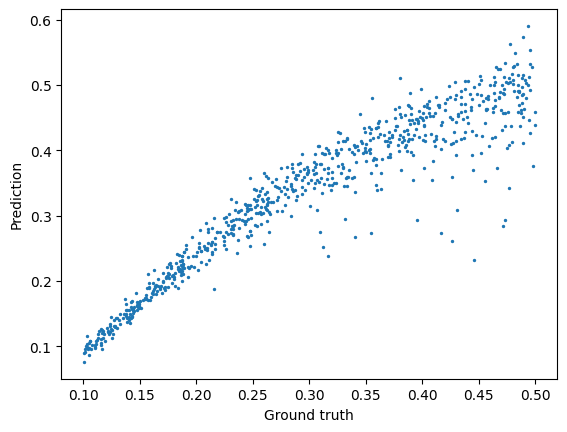

In [28]:
plt.scatter(lbl_cmd, yhat_cmd, s=2)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

plt.show()